# Optimising Ilic-Style Grating for Transverse Damping

Here, I will optimise the Ilic-style grating for transverse damping. I will initialise my optimisation problem with the Ilic grating. The goal is then to optimise for the width and position of the two elements in the Ilic-style grating. However, GRCWA uses spatial discretisation. Therefore I cannot directly compute gradients of a cost function with respect to the discrete width or position of the elements. Instead, the method is as follows:

1. When the unit cell is considered, it is sliced into Nx discrete components. While the width of the geometry is continuously defined outside of the code, it must be discretised within the code. We do this by effectively cutting off the boundary of each cell element, so that the element's width completely fills each slice. The slices on the boundary of the element which are partially filled will not be considered as part of the element.

2. To account for the partially-filled slices, I will instead change the permittivity of the element within that slice. Rather than ignoring the partially filled slices, I will add these slices as part of the cell element, but with a different permittivity. Since the elements have a permittivity of $\varepsilon_{Si} = 12$, and the substrate has permittivity $\varepsilon_{SiO_2} = 1$, then the adjusted permittivity of these partially filled slices will be $\varepsilon = (\varepsilon_{Si} - \varepsilon_{SiO_2})\frac{w-w_\text{filled}}{2*d/(Nx-1)}$. Here, $w_\text{filled}$ is the amount of the element which actually fills a unit cell, while $w$ is the width itself. Moreover, $\frac{d}{N_x-1}$ is the width of each slice, and the factor of 2 is there because there are two boundaries per element.

3. Optimise with respect to the changed boundary permittivities, which are continuously defined in GRCWA.


But how is this possible? Generally, GRCWA output the gradients of the cost function w.r.t. all of the permittivity values at the sliced grid points, let's call it $pCpe$. We need to manually convert the $pCpe$ into the effective derivative of the cost function with respect to width, call it $pCpw$. This will require many steps


1. Find $pCpe$ where only boundary $\varepsilon$'s are changed.

2. Find $pCpw$, given $pCpe$ from above. We have
$$
    \frac{\partial C}{\partial w} = \frac{\partial C}{\partial \varepsilon}\frac{\partial \varepsilon}{\partial w} = \frac{\varepsilon_{Si} - \varepsilon_{SiO_2}}{2\cdot d/(N_x-1)}\frac{\partial C}{\partial \varepsilon}
$$
since $w_\text{filled}$ is a step function, whose derivative is zero for the cases where this result matters.

## Creating an Optimisation Software

In [ ]:
from autograd import grad
import autograd.numpy as np

# Define the cost function, sin(x) + cos(y)
def cost_function(x):
    print(x)
    vars = [[],[],[],[]]
    vars[0:2] = x[0]
    vars[2:] = x[1]
    return np.sin(vars[0]) + np.cos(vars[1])

# Define gradient
grad_fun = grad(cost_function)


# Define gradient globally and update it with this function
def fun_grad(x):
    global grad
    grad = grad_fun(x)
    return cost_function(x)



# Initialise
init = [1., 2.]
max_iterations = 1000
step_size = 1
precision = 10

fun_grad(init)
index = 0

# Define loop to move in direction of grad until maximum is reached
while index <= max_iterations:
    
    # ------------------------------------------------------------------
    print("Attempt {}/{}".format(index, max_iterations), end='\r')
    # ---------------- --------------------------------------------------

    init = init + step_size*np.array(grad)
    fun_grad(init)

    if round(float(grad[0]),precision) == 0 and round(float(grad[1]),precision) == 0:
        print("Optimum reached after {} steps. Terminating the loop...".format(index))
        break
    
    index += 1

if index == max_iterations + 1:
    print("Solution could not converge after {} steps".format(index-1))

print("-------------------------------------------------")
print("Solution: {}".format(init))
print("Final gradient: {}".format(grad))
print("-------------------------------------------------")

## Applying the Optimisation Software


### Finding $w_\text{filled}$

In [ ]:
# What is w_filled?
import numpy as np
import matplotlib.pyplot as plt

Nx = 900001
Ny = 1

d = 1.8  # unit cell width
dy = 1e-1
x1 = 0.85*d # positions of blocks in unit cell
x2 = 0.25*d 
w1 = 0.15*d # width of blocks in unit cell
w2 = 0.35*d

def w_filled(Nx,Ny,d,dy,x1,x2,w1,w2):
    ones = np.ones((Nx,Ny))

    # Defining coordinate system
    x0 = np.linspace(0,d,Nx)
    y0 = np.linspace(0,dy,Ny)
    x, y = np.meshgrid(x0,y0, indexing='ij')

    # Need to add factor d/2*(Nx-1) as the x-positions in the meshgrid are the centers of bins, not actual bins. The bins have width d/(Nx-1)
    filter = (abs(x - x1) + (d/(2*(Nx-1))) <= w1/2) | (abs(x-x2) + (d/(2*(Nx-1))) <= w2/2)
    cell_geometry = np.ones((Nx,Ny))
    cell_geometry[filter] = 12
    # How many cells are filled?
    w_filled_e1 = sum(ones[abs(x-x1) + (d/(2*(Nx-1))) <= w1/2]*d/(Nx-1))
    w_filled_e2 = sum(ones[abs(x-x2) + (d/(2*(Nx-1))) <= w2/2]*d/(Nx-1))
    return w_filled_e1, w_filled_e2


# w_filled_e1, w_filled_e2 = w_filled(Nx,Ny,d,dy,x1,x2,w1,w2)
# plt.imshow(cell_geometry, interpolation='nearest', aspect='auto', extent=[0,1,d,0])
# plt.xlabel("y")
# plt.ylabel("x")
# plt.show()
# print(w1, w_filled_e1, (w1-w_filled_e1)/(2*d/(Nx-1)))
# print(w2, w_filled_e2, (w2-w_filled_e2)/(2*d/(Nx-1)))

### Changing Boundary Permittivity

In [ ]:
"""
----------------------------------------------------------------------------------------
                        Below is the code from the block above
"""
import numpy as np
import matplotlib.pyplot as plt


'''
Discretisation values
'''
# Truncation order
nG = 30
# Resolution 
Nx = 1000
Ny = 1

'''
Lattice cell parameters
'''
# Defining Ilic dimensions
d = 1.8  # unit cell width
dy = 1e-1
x1 = 0.85*d # positions of blocks in unit cell
x2 = 0.25*d 
w1 = 0.15*d # width of blocks in unit cell
w2 = 0.35*d

h = 0.5  # thickness of resonator layer
t = 0.5  # also equal to thickness of substrate layer

E_vacuum = 1.
E_Si = 3.5**2    # https://refractiveindex.info/ with k = n^2 (dielectric constant, refractive index)
E_SiO2 = 1.45**2  # https://refractiveindex.info/ with k = n^2 (dielectric constant, refractive index)

'''
Finding w_filled
'''

def w_filled(Nx,Ny,d,dy,x1,x2,w1,w2):
    ones = np.ones((Nx,Ny))

    # Defining coordinate system
    x0 = np.linspace(0,d,Nx)
    y0 = np.linspace(0,dy,Ny)
    x, y = np.meshgrid(x0,y0, indexing='ij')

    # Need to add factor d/2*(Nx-1) as the x-positions in the meshgrid are the centers of bins, not actual bins. The bins have width d/(Nx-1)
    filter = (abs(x - x1) + (d/(2*(Nx-1))) <= w1/2) | (abs(x-x2) + (d/(2*(Nx-1))) <= w2/2)
    cell_geometry = np.ones((Nx,Ny))*E_vacuum
    cell_geometry[filter] = E_Si
    # How many cells are filled?
    w_filled_e1 = sum(ones[abs(x-x1) + (d/(2*(Nx-1))) <= w1/2]*d/(Nx-1))
    w_filled_e2 = sum(ones[abs(x-x2) + (d/(2*(Nx-1))) <= w2/2]*d/(Nx-1))
    return cell_geometry, w_filled_e1, w_filled_e2

"""
----------------------------------------------------------------------------------------
"""


'''
Finding boundary indices
'''

# To start, the boundary permittivity is E_Si, but this will change
E_boundary = E_Si

def boundary_indices(x):
    global E_boundary
    # Define boundary permittivities
    eps_1d = x[:,0]
    boundary_indices = []
    for i in range(1,len(eps_1d)-1):
        lower_neighbor = eps_1d[i-1]
        current = eps_1d[i]
        upper_neighbor = eps_1d[i+1]
        if current == E_boundary and (lower_neighbor == E_Si or upper_neighbor == E_Si) and (lower_neighbor != upper_neighbor):
            # then we are at a boundary
            boundary_indices.append(i)
    return boundary_indices


'''
Now get the cell geometry with boundary permittivities adjusted for width
'''

def get_cell_geometry(vars,Nx,Ny,d,dy,x1,x2):
    w1 = vars[0]
    w2 = vars[1]

    # The design will be completely uniform in the y-direction.
    cell_geometry, w_filled_e1, w_filled_e2 = w_filled(Nx,Ny,d,dy,x1,x2,w1,w2)
    
    boundary_i = boundary_indices(cell_geometry)
    lower_boundary = boundary_i[0:2]
    upper_boundary = boundary_i[2:]
    
    # Calculate boundary permittivities using width proportion unaccounted for
    eps1 = (E_Si - E_SiO2)*(w1-w_filled_e1)/(2*d/(Nx-1))
    eps2 = (E_Si - E_SiO2)*(w2-w_filled_e2)/(2*d/(Nx-1))
    
    # Change boundary permittivities
    cell_geometry[lower_boundary,:] = eps1
    cell_geometry[upper_boundary,:] = eps2

    return cell_geometry
    



### Optimising for Reflectance

In [ ]:
""" Topology optimization of reflection of a single patterned layer."""
""" Nlopt is needed. For some reason does not work with latest version of numpy. Works fine with numpy 1.25.0 """

import grcwa

import autograd.numpy as np
from autograd import grad

import matplotlib.pyplot as plt

'''
Discretisation values
'''
# Truncation order
nG = 30
# Resolution 
Nx = 10000
Ny = 1

'''
Lattice cell parameters
'''
# Defining Ilic dimensions
d = 1.8  # unit cell width
dy = 1e-1
x1 = 0.85*d # positions of blocks in unit cell
x2 = 0.25*d 
w1 = 0.15*d # width of blocks in unit cell
w2 = 0.35*d

h = 0.5  # thickness of resonator layer
t = 0.5  # also equal to thickness of substrate layer

E_vacuum = 1.
E_Si = 3.5**2    # https://refractiveindex.info/ with k = n^2 (dielectric constant, refractive index)
E_SiO2 = 1.45**2  # https://refractiveindex.info/ with k = n^2 (dielectric constant, refractive index)

# Lattice constants. I will consider a lattice with square-shaped unit cells of size d x d (in natural units specified above)
L1 = [d, 0]
L2 = [0, dy]

'''
Light approach
'''
wavelength = 1.5
freq = 1./wavelength
# INPUT ANGLES IN DEGREES
theta = 0.
phi = 0.

# planewave excitation
planewave={'p_amp':0,'s_amp':1,'p_phase':0,'s_phase':0}


'''
Cost function for optimisation.

       x:   The dielectric constant on the 2D grids of size Nx*Ny
       
    Qabs:   A parameter for relaxation to better approach global optimal, at Qabs = inf, it will describe the real physics.
            It also be used to resolve the singular matrix issues by setting a large but finite Qabs, e.g. Qabs = 1e5
'''

def cost_function(vars,Qabs):
    # Cell geometry
    cell_geometry = get_cell_geometry(vars,Nx,Ny,d,dy,x1,x2)
    '''
    Building layers
                                    _________
                                     Layer 0 (vacuum)
       _____     ____               _________
      |     |   |    |               Layer 1 (pattern)
    __|     |___|    |__            _________
    |                    |   ...     Layer 2 (surface)
    |____________________|          _________
                                     Layer 3 (vacuum)
                                    _________
    '''
    freqcmp = freq*(1+1j/2/Qabs)
    ######### setting up RCWA
    obj = grcwa.obj(nG,L1,L2,freqcmp,theta*np.pi/180,phi*np.pi/180,verbose=0)
    # input layer information
    obj.Add_LayerUniform(0,E_vacuum)     # Layer 0
    obj.Add_LayerGrid(h,Nx,Ny)           # Layer 1
    obj.Add_LayerUniform(t,E_SiO2)       # Layer 2
    obj.Add_LayerUniform(0,E_vacuum)     # Layer 3
    obj.Init_Setup()


    '''
    Solving Maxwell's equations
    '''
    obj.MakeExcitationPlanewave(planewave['p_amp'],planewave['p_phase'],planewave['s_amp'],planewave['s_phase'],order = 0)    
    obj.GridLayer_geteps(cell_geometry.flatten())
    # compute reflection and transmission by order
    # Ri(Ti) has length obj.nG, to see which order, check obj.G; too see which kx,ky, check obj.kx obj.ky
    R,T= obj.RT_Solve(normalize=1)
    return R


Qabs = np.inf

cost_fun = lambda vars: cost_function(vars,Qabs)
grad_fun = grad(cost_fun)

def fun_grad(vars):
    global grad
    grad = grad_fun(vars)
    cost_val = cost_fun(vars)

    return cost_val

In [ ]:
'''
Optimisation Setup
'''

# Initialise
vars = [w1, w2]
max_iterations = 1000
step_size = 1
precision = 10

fun_grad(vars)
index = 1

# Define loop to move in direction of grad until maximum is reached
while index <= max_iterations:

    vars = vars + step_size*np.array(grad)
    cost_val = fun_grad(vars)

    # Printing parameters to command line
    if index == 1:
        print("{:<8} {:<8} {:<8} {:<8} {:<8} {:<8}".format("Step", "R", 'w1', 'w2'))
        
        global anim1
        anim1 = ax1.imshow(get_cell_geometry(vars), interpolation='nearest', vmin=0, vmax=E_Si, aspect='auto')
        cbar = plt.colorbar(anim1)
        cbar.set_label("Permittivity")
        plt.xlabel("y")
        plt.ylabel("x")
        plt.title(r"Step {}, $R = {}$".format(index, round(cost_val,5)))
        plt.savefig('grcwa/optimisation/figs/width/ilic_GRCWA_optimisation_width&pos_R_initial')
    else:
        anim1.set_data(get_cell_geometry(vars))
        plt.title(r"Step {}, $R = {}$".format(index, round(cost_val,5)))
        fig1.canvas.flush_events()

    if index != 1:
        print("{:<8} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(index, cost_val, vars[0],vars[1]))

    if round(float(grad[0]),precision) == 0 and round(float(grad[1]),precision) == 0:
        print("Optimum reached after {} steps. Terminating the loop...".format(index))
        break
    
    index += 1

if index == max_iterations + 1:
    print("Solution could not converge after {} steps".format(index-1))

plt.imshow(get_cell_geometry(vars), interpolation='nearest', vmin=0, vmax=E_Si, aspect='auto')
plt.xlabel("y")
plt.ylabel("x")
plt.title(r"Final result, Step {}, $R = {}$".format(index, round(cost_fun(vars),5)))
plt.savefig('grcwa/optimisation/figs/width/ilic_GRCWA_optimisation_width&pos_R_final')

# Test

Autograd ArrayBox with value [[ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 4.3126875]
 [12.25     ]
 [12.25     ]
 [12.25     ]
 [12.25     ]
 [12.25     ]
 [12.25     ]
 [12.25     ]
 [12.25     ]
 [12.25     ]
 [12.25     ]
 [12.25     ]
 [ 4.3126875]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 3.2979375]
 [12.25     ]
 [12.25     ]
 [12.25     ]
 [ 3.2979375]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]]
[[ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 4.3126875]
 [12.25     ]
 [12.25     ]
 [12.25     ]
 [12.25     ]
 [12.25     ]
 [12.25     ]
 [12.25     ]
 [12.25     ]
 [12.25     ]
 [12.25     ]
 [12.25     ]
 [ 4.3126875]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1.       ]
 [ 1

FileNotFoundError: [Errno 2] No such file or directory: 'grcwa/optimisation/actual_gradients/own_optimisation/test_initial.png'

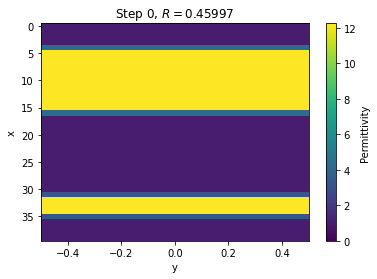

In [3]:
import grcwa
grcwa.set_backend('autograd')  # important!!

import autograd.numpy as np
from autograd import grad

import matplotlib.pyplot as plt

'''
Discretisation values
'''
# Truncation order
nG = 30
# Resolution 
Nx = 40
Ny = 1

'''
Lattice cell parameters
'''
# Defining Ilic dimensions
d = 1.8  # unit cell width
dy = 1e-1
x1 = 0.85*d # positions of blocks in unit cell
x2 = 0.25*d 
w1 = 0.15*d # width of blocks in unit cell
w2 = 0.35*d

h = 0.5  # thickness of resonator layer
t = 0.5  # also equal to thickness of substrate layer

E_vacuum = 1.
E_Si = 3.5**2    # https://refractiveindex.info/ with k = n^2 (dielectric constant, refractive index)
E_SiO2 = 1.45**2  # https://refractiveindex.info/ with k = n^2 (dielectric constant, refractive index)


# Lattice constants. I will consider a lattice with square-shaped unit cells of size d x d (in natural units specified above)
L1 = [d, 0]
L2 = [0, dy]

'''
Light approach
'''
wavelength = 1.5
freq = 1./wavelength
# INPUT ANGLES IN DEGREES
theta = 0.
phi = 0.

# planewave excitation
planewave={'p_amp':0,'s_amp':1,'p_phase':0,'s_phase':0}

'''
Finding w_filled
'''

def w_filled(Nx,Ny,d,dy,x1,x2,w1,w2):
    ones = np.ones((Nx,Ny))

    # Defining coordinate system
    x0 = np.linspace(0,d,Nx)
    y0 = np.linspace(0,dy,Ny)
    x, y = np.meshgrid(x0,y0, indexing='ij')

    # Need to add factor d/2*(Nx-1) as the x-positions in the meshgrid are the centers of bins, not actual bins. The bins have width d/(Nx-1)
    filter = (abs(x - x1) + (d/(2*(Nx-1))) <= w1/2) | (abs(x-x2) + (d/(2*(Nx-1))) <= w2/2)
    cell_geometry = np.ones((Nx,Ny))*E_vacuum
    cell_geometry[filter] = E_Si
    # How many cells are filled?
    w_filled_e1 = sum(ones[abs(x-x1) + (d/(2*(Nx-1))) <= w1/2]*d/(Nx-1))
    w_filled_e2 = sum(ones[abs(x-x2) + (d/(2*(Nx-1))) <= w2/2]*d/(Nx-1))
    return cell_geometry, w_filled_e1, w_filled_e2


'''
Finding boundary indices
'''

# To start, the boundary permittivity is E_Si, but this will change
E_boundary = E_Si

def boundary_indices(x):
    global E_boundary
    # Define boundary permittivities
    eps_1d = x[:,0]
    boundary_indices = []
    for i in range(1,len(eps_1d)-1):
        lower_neighbor = eps_1d[i-1]
        current = eps_1d[i]
        upper_neighbor = eps_1d[i+1]
        if current == E_boundary and (lower_neighbor == E_Si or upper_neighbor == E_Si) and (lower_neighbor != upper_neighbor):
            # then we are at a boundary
            boundary_indices.append(i)
    return boundary_indices


'''
Now get the cell geometry with boundary permittivities adjusted for width
'''

def get_cell_geometry(vars,Nx,Ny,d,dy,x1,x2):
    w1 = vars[0]
    w2 = vars[1]

    # The design will be completely uniform in the y-direction.
    cell_geometry, w_filled_e1, w_filled_e2 = w_filled(Nx,Ny,d,dy,x1,x2,w1,w2)
    
    boundary_i = boundary_indices(cell_geometry)
    lower_boundary = boundary_i[0:2]
    upper_boundary = boundary_i[2:]
    
    # Calculate boundary permittivities using width proportion unaccounted for
    eps1 = (E_Si - E_SiO2)*(w1-w_filled_e1)/(2*d/(Nx-1))
    eps2 = (E_Si - E_SiO2)*(w2-w_filled_e2)/(2*d/(Nx-1))
    
    # Change boundary permittivities
    cell_geometry = cell_geometry.tolist()
    cell_geometry[lower_boundary[0]][0] = eps1
    cell_geometry[lower_boundary[1]][0] = eps1
    cell_geometry[upper_boundary[0]][0] = eps2
    cell_geometry[upper_boundary[1]][0] = eps2
    cell_geometry = np.array(cell_geometry)

    print(cell_geometry)
    return cell_geometry







'''
Cost function for optimisation.

       x:   The dielectric constant on the 2D grids of size Nx*Ny
       
    Qabs:   A parameter for relaxation to better approach global optimal, at Qabs = inf, it will describe the real physics.
            It also be used to resolve the singular matrix issues by setting a large but finite Qabs, e.g. Qabs = 1e5
'''

def cost_function(vars,Qabs):
    # Cell geometry
    cell_geometry = get_cell_geometry(vars,Nx,Ny,d,dy,x1,x2)
    '''
    Building layers
                                    _________
                                     Layer 0 (vacuum)
       _____     ____               _________
      |     |   |    |               Layer 1 (pattern)
    __|     |___|    |__            _________
    |                    |   ...     Layer 2 (surface)
    |____________________|          _________
                                     Layer 3 (vacuum)
                                    _________
    '''
    freqcmp = freq*(1+1j/2/Qabs)
    ######### setting up RCWA
    obj = grcwa.obj(nG,L1,L2,freqcmp,theta*np.pi/180,phi*np.pi/180,verbose=0)
    # input layer information
    obj.Add_LayerUniform(0,E_vacuum)     # Layer 0
    obj.Add_LayerGrid(h,Nx,Ny)           # Layer 1
    obj.Add_LayerUniform(t,E_SiO2)       # Layer 2
    obj.Add_LayerUniform(0,E_vacuum)     # Layer 3
    obj.Init_Setup()


    '''
    Solving Maxwell's equations
    '''
    obj.MakeExcitationPlanewave(planewave['p_amp'],planewave['p_phase'],planewave['s_amp'],planewave['s_phase'],order = 0)    
    obj.GridLayer_geteps(cell_geometry.flatten())
    # compute reflection and transmission by order
    # Ri(Ti) has length obj.nG, to see which order, check obj.G; too see which kx,ky, check obj.kx obj.ky
    R,T= obj.RT_Solve(normalize=1)
    return R


Qabs = np.inf

cost_fun = lambda vars: cost_function(vars,Qabs)
grad_fun = grad(cost_fun)

def fun_grad(vars):
    global grad
    grad = grad_fun(vars)
    cost_val = cost_fun(vars)

    return cost_val

'''
Optimisation Setup
'''

# Initialise
vars = [w1, w2]
max_iterations = 100
step_size = 1
precision = 10

fun_grad(vars)
index = 0

# For animated figure ##############
plt.ion()
fig1, ax1 = plt.subplots()
####################################

# Define loop to move in direction of grad until maximum is reached
while index <= max_iterations:
    cost_val = fun_grad(vars)
    # Printing parameters to command line
    if index == 0:
        print("{:<8} {:<8} {:<8} {:<8}".format("Step", "R", 'w1', 'w2'))
        
        global anim1
        anim1 = ax1.imshow(get_cell_geometry(vars,Nx,Ny,d,dy,x1,x2), interpolation='nearest', vmin=0, vmax=E_Si, aspect='auto')
        cbar = plt.colorbar(anim1)
        cbar.set_label("Permittivity")
        plt.xlabel("y")
        plt.ylabel("x")
        plt.title(r"Step {}, $R = {}$".format(index, round(cost_val,5)))
        plt.savefig('grcwa/optimisation/actual_gradients/attempting_boundary_permittivity/own_optimisation/test_initial')
    else:
        anim1.set_data(get_cell_geometry(vars,Nx,Ny,d,dy,x1,x2))
        plt.title(r"Step {}, $R = {}$".format(index, round(cost_val,5)))
        fig1.canvas.flush_events()

    if index != 1:
        print("{:<8} {:<8.3f} {:<8.3f} {:<8.3f}".format(index, cost_val, vars[0],vars[1]))

    if round(float(grad[0]),precision) == 0 and round(float(grad[1]),precision) == 0:
        print("Optimum reached after {} steps. Terminating the loop...".format(index))
        break
    
    index += 1

if index == max_iterations + 1:
    print("Solution could not converge after {} steps".format(index-1))

plt.imshow(get_cell_geometry(vars,Nx,Ny,d,dy,x1,x2), interpolation='nearest', vmin=0, vmax=E_Si, aspect='auto')
plt.xlabel("y")
plt.ylabel("x")
plt.title(r"Final result, Step {}, $R = {}$".format(index, round(cost_fun(vars),5)))
plt.savefig('grcwa/optimisation/actual_gradients/attempting_boundary_permittivity/own_optimisation/test_final')

# GRCWA

In [33]:
""" Topology optimization of reflection of a single patterned layers ."""
""" Nlopt is needed. For some reason does not work with numpy 1.25.2. Works fine with numpy 1.25.0 """

import grcwa
grcwa.set_backend('autograd')  # important!!

import numpy as np
import autograd.numpy as npgrad
import matplotlib.pyplot as plt
from autograd import grad

try:
    import nlopt
    NL_AVAILABLE = True
except ImportError:
    NL_AVAILABLE = False

if NL_AVAILABLE == False:
    raise Exception('Please install NLOPT')

'''
Discretisation values
'''
# Truncation order
nG = 30
# Resolution 
Nx = 30
Ny = 1


obj_order = 0  # <----- WHICH ORDER DO YOU WANT TO LOOK AT?

'''
Lattice cell parameters
'''
# Defining Ilic dimensions
d = 1.8  # unit cell width
dy = 1e-1
x1 = 0.85*d # positions of blocks in unit cell
x2 = 0.25*d 
w1 = 0.15*d # width of blocks in unit cell
w2 = 0.35*d

h = 0.5  # thickness of resonator layer
t = 0.5  # also equal to thickness of substrate layer

E_vacuum = 1.
E_Si = 3.5**2    # https://refractiveindex.info/ with k = n^2 (dielectric constant, refractive index)
E_SiO2 = 1.45**2  # https://refractiveindex.info/ with k = n^2 (dielectric constant, refractive index)

# Lattice constants. I will consider a lattice with square-shaped unit cells of size d x d (in natural units specified above)
L1 = [d, 0]
L2 = [0, dy]

'''
Light approach
'''
wavelength = 1.5
freq = 1./wavelength
# INPUT ANGLES IN DEGREES
theta = 0.
phi = 0.

# planewave excitation
planewave={'p_amp':0,'s_amp':1,'p_phase':0,'s_phase':0}


'''
Cost function for optimisation.

       x:   The dielectric constant on the 2D grids of size Nx*Ny
       
    Qabs:   A parameter for relaxation to better approach global optimal, at Qabs = inf, it will describe the real physics.
            It also be used to resolve the singular matrix issues by setting a large but finite Qabs, e.g. Qabs = 1e5
'''

def cost_function(x,Qabs):
    freqcmp = freq*(1+1j/2/Qabs)
    ######### setting up RCWA
    obj = grcwa.obj(nG,L1,L2,freqcmp,theta*np.pi/180,phi*np.pi/180,verbose=0)
    # input layer information
    obj.Add_LayerUniform(0,E_vacuum)     # Layer 0
    obj.Add_LayerGrid(h,Nx,Ny)           # Layer 1
    obj.Add_LayerUniform(t,E_SiO2)       # Layer 2
    obj.Add_LayerUniform(0,E_vacuum)     # Layer 3
    '''
                                    _________
                                     Layer 0 (vacuum)
       _____     ____               _________
      |     |   |    |               Layer 1 (pattern)
    __|     |___|    |__            _________
    |                    |   ...     Layer 2 (surface)
    |____________________|          _________
                                     Layer 3 (vacuum)
                                    _________
    '''
    obj.Init_Setup()

    obj.MakeExcitationPlanewave(planewave['p_amp'],planewave['p_phase'],planewave['s_amp'],planewave['s_phase'],order = 0)    
    obj.GridLayer_geteps(x)
    # compute reflection and transmission
    R,T= obj.RT_Solve(normalize=1)
    print(x)
    print(R)
    return R


# nlopt function
ctrl = 0
Qabs = npgrad.inf
fun = lambda x: cost_function(x,Qabs)
grad_fun = grad(fun)
def fun_nlopt(x,gradn):
    global ctrl
    gradn[:] = grad_fun(x)
    y = fun(x)
    
    print('Step = ',ctrl,', R = ',y)
    # Visualising the geometry ____________________________________________________________________
    if ctrl == 0:
        global anim1
        anim1 = ax1.imshow(np.reshape(x, (Nx,Ny)), interpolation='nearest', vmin=1, vmax=E_Si, aspect='auto')
        cbar = plt.colorbar(anim1)
        cbar.set_label("Permittivity")
        plt.xlabel("y")
        plt.ylabel("x")
        plt.title(r"Step {}, $R = {}$".format(ctrl, round(y,5)))
        plt.savefig('grcwa/optimisation/figs/permittivity/ilic_GRCWA_optimisation_permittivity_R_initial')
    else:
        anim1.set_data(np.reshape(x, (Nx,Ny)))
        plt.title(r"Step {}, $R = {}$".format(ctrl, round(y,5)))
        fig1.canvas.flush_events()
    # _____________________________________________________________________________________________
    ctrl += 1
    return fun(x)


'''
Cell geometry
'''
# Unit cell geometry (rows, cols)
cell_geometry = np.ones((Nx,Ny), dtype=float)*E_vacuum

x0 = np.linspace(0,d,Nx)
y0 = np.linspace(0,dy,Ny)
x, y = np.meshgrid(x0,y0, indexing='ij')
# The design will be completely uniform in the y-direction.
filter = (abs(x-x1) <= w1/2) | (abs(x-x2) <= w2/2)
cell_geometry[filter] = E_Si

grad_fun(cell_geometry)

Autograd ArrayBox with value [[ 1.  ]
 [ 1.  ]
 [ 1.  ]
 [12.25]
 [12.25]
 [12.25]
 [12.25]
 [12.25]
 [12.25]
 [12.25]
 [12.25]
 [12.25]
 [12.25]
 [ 1.  ]
 [ 1.  ]
 [ 1.  ]
 [ 1.  ]
 [ 1.  ]
 [ 1.  ]
 [ 1.  ]
 [ 1.  ]
 [ 1.  ]
 [ 1.  ]
 [12.25]
 [12.25]
 [12.25]
 [12.25]
 [ 1.  ]
 [ 1.  ]
 [ 1.  ]]
Autograd ArrayBox with value 0.3532646739084522


array([[ 0.00425969],
       [-0.00213247],
       [-0.00939448],
       [-0.01530656],
       [-0.00333522],
       [ 0.01390901],
       [ 0.01298444],
       [-0.0017742 ],
       [-0.00589387],
       [ 0.0067    ],
       [ 0.01562975],
       [ 0.00723051],
       [-0.00640656],
       [-0.0088872 ],
       [-0.00744012],
       [-0.00558284],
       [-0.00328627],
       [-0.0010194 ],
       [ 0.0016206 ],
       [ 0.00435679],
       [ 0.00784503],
       [ 0.01148655],
       [ 0.01593383],
       [ 0.01422072],
       [-0.0086937 ],
       [-0.01487974],
       [ 0.00580441],
       [ 0.01520844],
       [ 0.01424019],
       [ 0.01032984]])